# Imports
___

In [47]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, TwoSlopeNorm
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

from nltk.stem import WordNetLemmatizer, PorterStemmer

# Bring in Cleaned Dataset
___

In [48]:
posts = pd.read_csv('../Datasets/reddit_posts_clean.csv')

In [49]:
posts.head()

,title,selftext,subreddit,created_utc,target,all_text,word_count,sentiment
0,Can a nuclear bomb set off another nuke?,NaN,askscience,1646168184,0,Can a nuclear bomb set off another nuke?,8,-0.4939
1,"God forbid, Russia decides to go for the n nuc...",NaN,askscience,1646168000,0,"God forbid, Russia decides to go for the n nuc...",15,-0.0516
2,Why can the common cold coexist with Covid?,NaN,askscience,1646167864,0,Why can the common cold coexist with Covid?,8,0.0000
3,What fuel burns for the longest?,NaN,askscience,1646167761,0,What fuel burns for the longest?,6,0.0000
4,Electromagnetic force,NaN,askscience,1646167434,0,Electromagnetic force,2,0.0000


#### Fix Selftext Column

In [50]:
posts.isna().sum()

title             0
selftext       1673
subreddit         0
created_utc       0
target            0
all_text          0
word_count        0
sentiment         0
dtype: int64

In [51]:
posts.fillna('', inplace=True)

In [52]:
posts.head()

,title,selftext,subreddit,created_utc,target,all_text,word_count,sentiment
0,Can a nuclear bomb set off another nuke?,,askscience,1646168184,0,Can a nuclear bomb set off another nuke?,8,-0.4939
1,"God forbid, Russia decides to go for the n nuc...",,askscience,1646168000,0,"God forbid, Russia decides to go for the n nuc...",15,-0.0516
2,Why can the common cold coexist with Covid?,,askscience,1646167864,0,Why can the common cold coexist with Covid?,8,0.0000
3,What fuel burns for the longest?,,askscience,1646167761,0,What fuel burns for the longest?,6,0.0000
4,Electromagnetic force,,askscience,1646167434,0,Electromagnetic force,2,0.0000


In [53]:
posts.isna().sum()

title          0
selftext       0
subreddit      0
created_utc    0
target         0
all_text       0
word_count     0
sentiment      0
dtype: int64

## Null model
___

In [54]:
posts['subreddit'].value_counts(normalize=True)

unpopularopinion    0.52315
askscience          0.47685
Name: subreddit, dtype: float64

#### The null model will predict unpopular opinion every time, and will be right 52.31% of the time

# Random Forest Model
___

In [55]:
X = posts.drop(columns=['subreddit', 'target'])
y = posts['subreddit']

In [56]:
# Split the data into the training and testing sets to train classification model
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [57]:
def get_title(df):
    return df['all_text']

get_title_trasnformer = FunctionTransformer(get_title, validate=False)

In [58]:
def get_columns(df):
    return df[['sentiment']].values

get_columns_trasnformer = FunctionTransformer(get_columns, validate=False)

In [59]:
def sparse_to_dense(sparse_matrix):
    return np.asarray(sparse_matrix.todense())

sparse_to_dense_trasnformer = FunctionTransformer(sparse_to_dense, validate=False)

In [60]:
def lemmatize_post(post):
    lemmatizer = WordNetLemmatizer()
    split_post = post.split(' ')
    return ''.join([lemmatizer.lemmatize(word) for word in split_post])

In [61]:
def stem_post(post):
    p_stemmer = PorterStemmer()
    split_post = post.split(' ')
    return ''.join([p_stemmer.stem(word) for word in split_post])

In [62]:
pipe1 = Pipeline([
    ('title_transform', get_title_trasnformer),
    ('cvec', CountVectorizer()),
    ('sparse_to_dense_trasnformer', sparse_to_dense_trasnformer)
])

In [63]:
pipe2 = Pipeline([
    ('feature_union', FeatureUnion([
        ('pipe1', pipe1),
        ('other_cols', get_columns_trasnformer),
    ])),
    ('model', RandomForestClassifier())
])

In [64]:
all_params = {
    'feature_union__pipe1__cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'feature_union__pipe1__cvec__min_df': [2, 3],
    'feature_union__pipe1__cvec__max_df': [.9, .95],
    'feature_union__pipe1__cvec__stop_words' : [None, 'english'],
    'model__n_estimators': [100, 150, 200],
    'model__max_depth': [None, 1, 2, 3, 4, 5],
}
gs_tree = GridSearchCV(pipe2, param_grid=all_params, cv=5)
gs_tree.fit(X_train, y_train)
print(gs_tree.best_score_)
gs_tree.best_params_

KeyboardInterrupt: 

___
#### Tracking Performance:

Paramemters <br>
cvec__max_df: 0.9 <br>
cvec__max_features: 4000 <br>
cvec__min_df: 2 <br> 
cvec__stop_words: None <br>
model__max_depth: None <br>
model__n_estimators: 150 <br>
and word count: <br>
 
__Model score: 0.8909532282663954__

In [ ]:
gs_tree.score(X_train, y_train)

In [ ]:
gs_tree.score(X_test, y_test)

In [ ]:
# Get predictions
preds = gs_tree.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

## Creating Colormap For Confusion Matrix
___
https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

In [ ]:
x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
z = (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))

fig, ax = plt.subplots(1,1)
im = ax.imshow(z)
fig.colorbar(im)
ax.yaxis.set_major_locator(plt.NullLocator()) # remove y axis ticks
ax.xaxis.set_major_locator(plt.NullLocator()) # remove x axis ticks

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(2,2, figsize=(5,5))

# the colormaps we'll be trying out
cmap_list = ['RdPu', 'spring', 'PRGn', 'gnuplot']

for ax, name in zip(axes.flatten(), cmap_list):
    im = ax.imshow(z, aspect='auto',  cmap=plt.get_cmap(name))
    ax.yaxis.set_major_locator(plt.NullLocator())   # remove y axis ticks
    ax.xaxis.set_major_locator(plt.NullLocator())   # remove x axis ticks
    ax.set_aspect('equal', adjustable='box')        # make subplots square
    ax.set_title(f'Cmap: {name}', fontsize=18)      # add a title to each
    divider = make_axes_locatable(ax)               # make colorbar same size as each subplot
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)

In [ ]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

In [ ]:
def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
#     cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp



In [ ]:
# standard
x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
z = (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))
hex_list = ["182f2e","f7e2db","fbda53","e9b498","31726c","5caaa7","94b7b6","9f5a44","4e949c"]
#my list of values

fig, ax = plt.subplots(1,1)
im = ax.imshow(z, cmap=get_continuous_cmap(hex_list))
fig.colorbar(im)
ax.yaxis.set_major_locator(plt.NullLocator()) # remove y axis ticks
ax.xaxis.set_major_locator(plt.NullLocator()) # remove x axis ticks

In [ ]:
#diverging
x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
z = (np.sqrt(x**2 + y**2) + np.sin(x**2 + y**2))
z = 7*(z/z.max())-2 #shift range to between -2 and 5

center = 0
divnorm = TwoSlopeNorm(vmin=z.min(),vcenter=center, vmax=z.max())

fig, ax = plt.subplots(1,1)
hex_list = ["041322","094947","38707a","97abaa","889aa4","7c8b8d","b5591f"]
im = ax.imshow(z, cmap=get_continuous_cmap(hex_list), norm=divnorm)
fig.colorbar(im)
ax.yaxis.set_major_locator(plt.NullLocator()) # remove y axis ticks
ax.xaxis.set_major_locator(plt.NullLocator()) # remove x axis ticks

In [ ]:
my_cmap = get_continuous_cmap(hex_list = ["094947","38707a","889aa4","97abaa", "f2e2dd"])

In [ ]:
newcmp = ListedColormap('#58a39e', '#745b62')

## Generating Confusion Matrix

In [65]:
with warnings.catch_warnings(record=True):
# remove depricated function warning

    plot_confusion_matrix(gs_tree, X_test, y_test, cmap=my_cmap, values_format='d')
    plt.grid();

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Creating Outcomes Distribution 

In [ ]:
tree_pred_df = pd.DataFrame({'true_values': y_test.map({'unpopularopinion':0, 'askscience': 1}),
                       'pred_probs': gs_tree.predict_proba(X_test)[:,1]})
tree_pred_df

In [ ]:
with warnings.catch_warnings(record=True):
# remove depricated function warning

    plt.figure(figsize = (12, 5))

    colors =['#216a61', '#745b62']
    sns.set_theme(palette=sns.color_palette(colors))

    # plot distributions of predicted probabilities by actual values
    for group in tree_pred_df.groupby('true_values'):
    #     sns.histplot(group[1], kde = True, bins = 20, label = f'Actual Outcome = {group[0]}', palette='crest')
        sns.distplot(group[1], kde = True, bins = 20, label = f'Actual Outcome = {group[0]}')
    #     color=['#207567', '#AA722A']
    plt.xlabel('Predicted Probability that Outcome = 1')
    plt.ylabel('Frequency')
    plt.legend();

# Random Forest with Stemming and Lemmatizing 
___

In [66]:
X = posts.drop(columns=['subreddit', 'target'])
y = posts['subreddit']

In [67]:
# Split the data into the training and testing sets to train classification model
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [68]:
pipe3 = Pipeline([
    ('title_transform', get_title_trasnformer),
    ('cvec', CountVectorizer()),
    ('sparse_to_dense_trasnformer', sparse_to_dense_trasnformer)
])

In [69]:
pipe4 = Pipeline([
    ('feature_union', FeatureUnion([
        ('pipe3', pipe3),
        ('other_cols', get_columns_trasnformer),
    ])),
    ('model', RandomForestClassifier())
])

In [70]:
all_params = {
    'feature_union__pipe3__cvec__preprocessor': [None, lemmatize_post, stem_post],
    'feature_union__pipe3__cvec__max_features': [4_000],
    'feature_union__pipe3__cvec__min_df': [2],
    'feature_union__pipe3__cvec__max_df': [.9],
    'feature_union__pipe3__cvec__stop_words' : [None],
    'model__n_estimators': [150],
    'model__max_depth': [None],
}
gs_tree = GridSearchCV(pipe4, param_grid=all_params, cv=5)
gs_tree.fit(X_train, y_train)
print(gs_tree.best_score_)
gs_tree.best_params_

KeyboardInterrupt: 

___
#### Tracking Performance:
 with porter stemmer and lemmatizer: <br>
 {'feature_union__pipe3__cvec__max_df': 0.9,
 'feature_union__pipe3__cvec__max_features': 4000,
 'feature_union__pipe3__cvec__min_df': 2,
 'feature_union__pipe3__cvec__preprocessor': None,
 'feature_union__pipe3__cvec__stop_words': None,
 'model__max_depth': None,
 'model__n_estimators': 150}
 Model score: 0.8816980172852059
___

## Using Logistic Regression
____

In [71]:
pipe_log_reg = Pipeline([
    ('feature_union', FeatureUnion([
        ('pipe3', pipe3),
        ('other_cols', get_columns_trasnformer),
    ])),
    ('model', LogisticRegression())
])

In [72]:
all_params = {
    'feature_union__pipe3__cvec__preprocessor': [None, lemmatize_post, stem_post],
    'feature_union__pipe3__cvec__max_features': [4_000],
    'feature_union__pipe3__cvec__min_df': [2],
    'feature_union__pipe3__cvec__max_df': [.9],
    'feature_union__pipe3__cvec__stop_words' : [None],
}
gs_logreg = GridSearchCV(pipe_log_reg, param_grid=all_params, cv=5)
gs_logreg.fit(X_train, y_train)
print(gs_logreg.best_score_)
gs_logreg.best_params_

0.9009481443823081


{'feature_union__pipe3__cvec__max_df': 0.9,
 'feature_union__pipe3__cvec__max_features': 4000,
 'feature_union__pipe3__cvec__min_df': 2,
 'feature_union__pipe3__cvec__preprocessor': None,
 'feature_union__pipe3__cvec__stop_words': None}

In [73]:
logreg_pred_df = pd.DataFrame({'true_values': y_test.map({'unpopularopinion':0, 'askscience': 1}),
                       'pred_probs': gs_logreg.predict_proba(X_test)[:,1]})
logreg_pred_df

,true_values,pred_probs
1801,0,0.249490
878,1,0.114408
378,1,0.025824
1347,0,0.972573
1303,0,0.964841
...,...,...
520,1,0.225651
504,1,0.052580
619,1,0.061777
466,1,0.069711


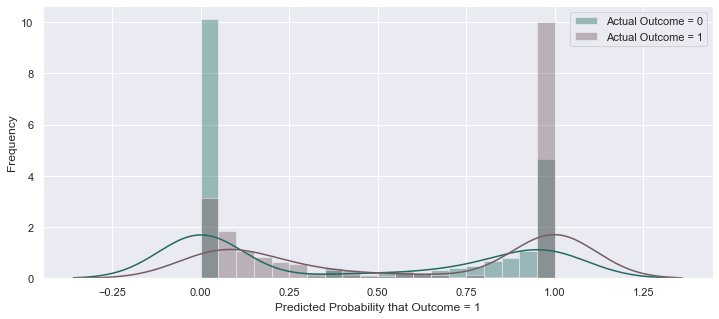

In [74]:
with warnings.catch_warnings(record=True):
# remove depricated function warning

    plt.figure(figsize = (12, 5))

    colors =['#216a61', '#745b62']
    sns.set_theme(palette=sns.color_palette(colors))

    # plot distributions of predicted probabilities by actual values
    for group in logreg_pred_df.groupby('true_values'):
    #     sns.histplot(group[1], kde = True, bins = 20, label = f'Actual Outcome = {group[0]}', palette='crest')
        sns.distplot(group[1], kde = True, bins = 20, label = f'Actual Outcome = {group[0]}')
    #     color=['#207567', '#AA722A']
    plt.xlabel('Predicted Probability that Outcome = 1')
    plt.ylabel('Frequency')
    plt.legend();

## Finding Top Features

In [75]:
with warnings.catch_warnings(record=True):
# remove depricated function warning
    logreg_coefs = gs_logreg.best_estimator_.named_steps.model.coef_
    logreg_predictors = gs_logreg.best_estimator_.named_steps['feature_union'].transformer_list[0][1].named_steps['cvec'].get_feature_names()

In [76]:
#Zip them together and turn them into a list
logreg_coef_predictor = list(zip(logreg_coefs[0],logreg_predictors))

In [77]:
logreg_coef_predictor = pd.DataFrame(logreg_coef_predictor, columns=('logreg_coefs', 'logreg_predictors'))

In [78]:
#ask science predictors
logreg_coef_predictor.sort_values(by='logreg_coefs').head(10)

,logreg_coefs,logreg_predictors
2769,-2.263167,why
2754,-2.216648,what
1219,-2.207419,how
1881,-1.978589,possible
408,-1.734004,can
1984,-1.272307,question
729,-1.185828,does
1677,-1.057973,nuclear
581,-1.045796,could
2513,-1.045105,there


In [79]:
#unpopular opinion best predictors
logreg_coef_predictor.sort_values(by='logreg_coefs', ascending=False).head(10)

,logreg_coefs,logreg_predictors
1796,1.870664,people
2618,1.574372,ukraine
1485,1.493564,love
2219,1.372659,should
736,1.355347,don
1661,1.326560,no
1671,1.284446,not
2800,1.270988,world
1758,1.247293,overrated
1978,1.238405,putin
